# Implementation of the Policy Iteration Algorithm on the Frozen Lake

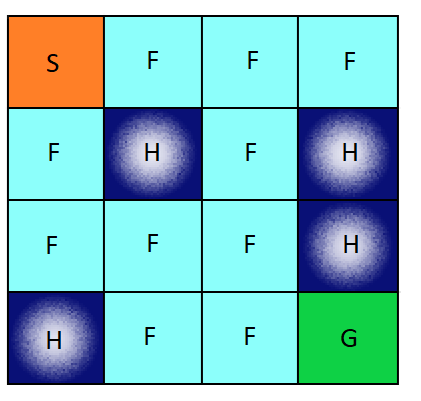

Imagine, there is a frozen lake from your home to office, you should walk on the frozen lake to reach your office. But oops! there will be a hole in the frozen lake in between, so you have to be careful while walking in the frozen lake to avoid getting trapped at holes. Look at the below figure where,

S is the starting position (Home)
F is the Frozen lake where you can walk
H is the Hole which you have to be so careful about
G is the Goal (office)
title

Okay, now let us use our agent instead of you to find the correct way to reach the office. The agent goal is to find the optimal path to reach from S to G without getting trapped at H. How an agent can achieve this? We give +1 point as a reward to the agent if it correctly walks on the frozen lake and 0 points if it falls into the hole. So that agent could determine which is the right action. An agent will now try to find the optimal policy. Optimal policy implies taking the correct path which maximizes the agent reward. If the agent is maximizing the reward, apparently agent is learning to skip the hole and reach the destination.

In [1]:
import gym
import numpy as np

## <a id="everything"></a>Summary of the RL theory learned so far

<div class="alert-success">
<ul>
<li> A **Markov Decision Process** (MDP) is a 4-tuple $\langle S,A,p,r \rangle$. $S$ is the state space, $A$ is the action space, $p(s'|s,a)$ the transition model and $r(s,a)$ the reward model.
<li> A **policy** is a mapping $\pi:S\rightarrow A$ that specifies what to do in a given state.
<li> **Value function of a policy**: $V^\pi(s)=\mathbb{E}\left( \sum\limits_{t = 0}^T \gamma^t r_t \bigg| s_0 = s, \pi \right)$
<li> **State-action value function of a policy**: $Q^\pi(s,a) = \mathbb{E}\left( \sum\limits_{t = 0}^T \gamma^t r_t \bigg| s_0 = s, a_0=a, \pi \right)$
<li> **Optimal policy $\pi^*$** dominates every other possible policy in every state: $\forall s, \ V^*(s) = V^{\pi^*}(s) \geq V^\pi(s)$
</ul>

<div class="alert-success">
<ul>
<li> **Expectation equation**: $V^\pi$ is the only solution to $V\left(s\right) =  r\left(s,\pi\left(s\right)\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,\pi\left(s\right)\right) V\left(s'\right)$<br>
Similarly, $Q^\pi$ is the only solution to $Q\left(s,a\right) = r\left(s,a\right) + \gamma \sum\limits_{s'\in S} p\left(s'|s,a\right) Q\left(s', \pi\left(s'\right)\right)$
<li> **Optimality equation**: $V^*$ is the only solution to $V(s)  = \max\limits_{a\in A} \left\{ r(s,a) + \gamma \sum\limits_{s'\in S} p(s'|s,a) V(s') \right\}$<br>
Similarly, $Q^*$ is the only solution to $Q(s,a) = r(s,a) + \gamma \sum\limits_{s'\in S}p(s'|s,a) \max\limits_{a'\in A} Q(s',a')$
</ul>
</div>

<div class="alert-success">
<li> **Value Iteration**: finding $V^*$ (or $Q^*$) by repeatedly applying the Bellman Optimal Equation to any initial function
<li> **Policy Iteration**: finding $\pi^*$ from any initial policy by building the sequence $\pi_{n+1}(s) = \arg\max_{a\in A} Q^{\pi_n}(s,a)$ that converges towards $\pi^*$; $Q^{\pi_n}(s,a)$ is computing using the Bellman Expectation Equation
</div>

## <a id="gym"></a>Some Gym notions

Gym environments all are encapsulated so that they have the same API. This can be described by calling `help(gym.Env)` Namely, they all have 5 methods and 3 attributes.

**Methods**:
- `step` --- Runs one timestep of the environment's dynamics. When end of episode is reached, you are responsible for calling `reset()`  to reset this environment's state. Accepts an action and returns a tuple (observation, reward, done, info).
- `reset` --- Resets the state of the environment and returns an initial observation.
- `render` --- Renders the environment. The set of supported modes varies per environment. See `help(gym.Env.render)` for details and arguments.
- `close` --- Cleans everything up, shuts the light and closes the door.
- `seed` --- Sets the seed for this env's random number generator(s).

**Attributes**:
- `action_space` --- The Space(*) object corresponding to valid actions.
- `observation_space` --- The Space(*) object corresponding to valid observations.
- `reward_range` --- A tuple corresponding to the min and max possible rewards.

(*) `Space` is a class (`help(gym.Space)`) that defines a set, be it continuous or discrete, with some useful methods. It is used specifically as the type of the action and observation spaces.

Beyond those common API methods, some class-specific methods or attributes can be accessed by using the `unwrapped` attribute of each environment (if present) as in the example above.

**General references on OpenAI Gym:**
- [The short description paper](https://arxiv.org/pdf/1606.01540.pdf)
- [The github page](https://github.com/openai/gym/blob/master/gym/envs/toy_text/discrete.py) (the most useful resource!)
- [The general introduction to Gym](https://gym.openai.com/docs/)
- [The deprecated list of environments](https://gym.openai.com/envs/) (refer to the github page for the latest version).

## Looking at the environment

In [2]:
env=gym.make('FrozenLake-v0')

[2019-08-30 16:59:42,815] Making new env: FrozenLake-v0


In [3]:
env.render()

SFFF
FHFH
FFFH
HFFG



|  S : starting point, safe  
|  F : frozen surface, safe  
|  H : hole, fall to your doom  
|  G : goal, where your office is located  
|  
|  The episode ends when you reach the goal or fall in a hole.  
|  You receive a reward of 1 if you reach the goal, and zero otherwise.

### State Space, Action Space, Model of the environment

In [4]:
print(env.observation_space.n)

16


In [5]:
print(env.action_space.n)

4


**action space**:  
left=0, down=1, right=2, up=3

In [6]:
#model of the environment - example for first state
env.P[0]

{0: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False)],
 1: [(0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False)],
 2: [(0.3333333333333333, 4, 0.0, False),
  (0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)],
 3: [(0.3333333333333333, 1, 0.0, False),
  (0.3333333333333333, 0, 0.0, False),
  (0.3333333333333333, 0, 0.0, False)]}

In [7]:
env.P[0][0] #first state, action moving left

[(0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 0, 0.0, False),
 (0.3333333333333333, 4, 0.0, False)]

**env.P(s) gives you for each possible action a:**
* all the possible next states s'
* the probability model p(s'|s,a)
* and the reward r(s'|s,a)
* A boolean if s' is a terminal state or no

### Parameters of the Value Iteration Algorithm
* **The discount rate $\gamma$**: you can start with a value $\gamma=0.8$ and varying it to see its impact on the optimal policy 
* **The convergence threshold**: a threshold of $10^-5$ is a good target
* **The number of iterations**: The maximum number of updates for the value function: should be large enough to allow convergence. You can start with 100,000 iterations.

In [18]:
gamma=0.9
num_iterations=100000
thresold=0.000001

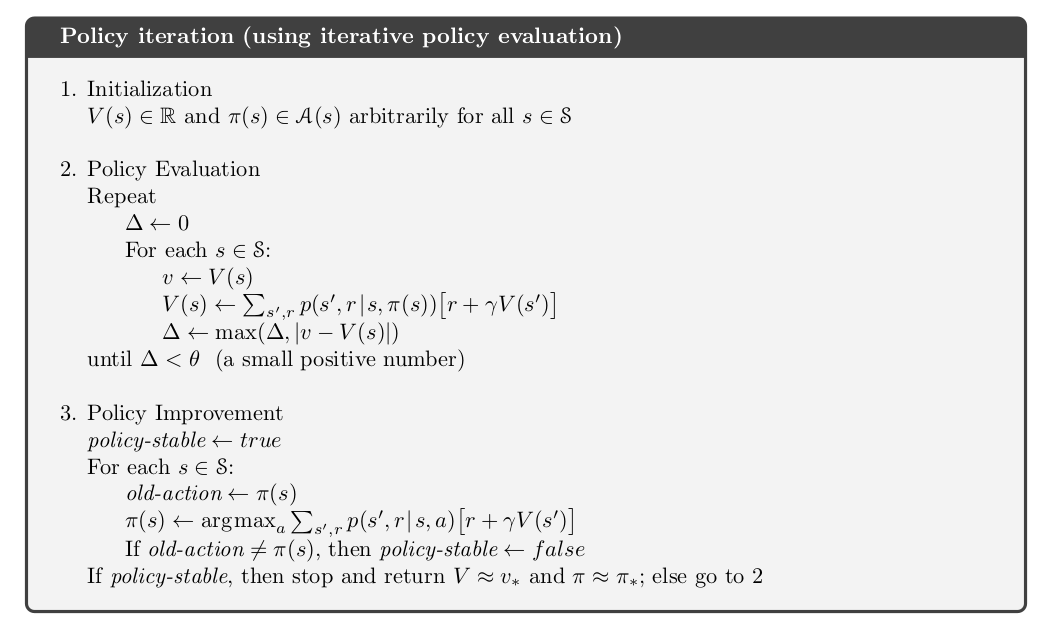

## Steps to implement the Policy Iteration algorithm

### 1. Code a function for the policy evaluation step
##### This function takes as parameter a policy $\pi$ (plus eventually the parameters of the algo: gamma, threshold, number of iterations...) and do the following; 

* Initialization of the Value Function for each state V(s) (numpy table with zero initial values)

* First Loop over all the iterations 

* For each state of the state space (loop over states)
* Take the action a given by the policy ($a=\pi(s)$) and do one transition
* Store the transition (transition proba $p(s'|s,a)$, next state s', immediate reward $r(s'|s,a)$) for each possible next state
* And compute the updated value function for the state: $V^{new}_{\pi}(s)=\sum\limits_{s'\in S} p(s'|s,a)*(r(s'|s,a)+\gamma*V(s'))$
* Check if V has reached convergence: ($ \sum\limits_{s \in S} |V_{\pi}(s)-V^{new}_{\pi}(s)| < threshold$): 
    if so break the loop over the iterations
* Return the latest value of the Value Function $V_{\pi}$

### 2. Code a function for the policy improvement step
##### This function takes as parameter a value function table V,  (plus eventually the parameters of the algo: gamma, threshold, number of iterations...) and do the following: 
* For all the states in the state space (loop over all the states)
* Loop over all the possible actions and store the transition (transition proba $p(s'|s,a)$, next state s', immediate reward $r(s'|s,a)$)
* Compute $Q(s,a)=\sum\limits_{s'\in S} p(s'|s,a)*(r(s'|s,a)+\gamma*V(s'))$ for each action a
* Compute $\pi(s)=\arg\max\limits_{a \in A} Q(s,a)$
* Return $\pi$ the updated policy

### 3. Code a function "policy_iteration" to iterate between the policy evaluation step and the policy improvement step
* Random Initialization of the policy
* Loop over the number of iterations
* Do the Policy Evaluation step for the current policy (with the function coded before): this gives you a value function
* Do the Policy Improvement step by plugging this value function to the coded function for Policy Improvement: this gives you an updated policy
* Check if the policy has reached convergence by verifying if the new policy is the same than the old one for every state: if so, break the loop over the iterations
* Return the latest policy

### Policy Evaluation Step: Computing the value Function of the policy being evaluated

In [13]:
def compute_value_function(policy, gamma=0.9, num_iterations=10000):
    
    # initialize value table with zeros
    value_table = np.zeros(env.observation_space.n)
    
    # set the threshold
    threshold = 1e-5
    
    for i in range(num_iterations):
        
        # copy the value table to the updated_value_table
        old_value_table = np.copy(value_table)

        # for each state in the environment, select the action according to the policy and compute the value table
        for state in range(env.observation_space.n):
            # select the action from the policy 
            action = policy[state]
            
            # build the value table with the selected action
            # V(s)<-sum over s' (p(s'|s,a)*(r(s'|s,a)+gamma*V(s')))
            value_table[state] = sum([trans_prob * (reward_prob + gamma * old_value_table[next_state]) 
                        for trans_prob, next_state, reward_prob, _ in env.P[state][action]])
            
        # break if the sum of the absolute diffences between the old and new value functions is inferior to the threshold
        if (np.sum((np.fabs(old_value_table - value_table))) <= threshold):
            break
            
    return value_table

### Policy Improvement step

In [14]:
 def extract_policy(env, value_table, gamma=0.9):
    # initializing the policy table
    policy=np.zeros(env.observation_space.n)
    
    for state in range(env.observation_space.n):
        
        # initializing the Q_table for each state
        Q_table=np.zeros(env.action_space.n)
        
        # compute Q Value for each actions of the state
        #Q_value(state,action) <-sum over s' (p(s'|s,a)*(r(s'|s,a)+gamma*V(s')))
        for action in range(env.action_space.n):
            for next_s in env.P[state][action]:
                trans_prob, next_state, reward_prob, _=next_s
                # adding the next_state_rewards for the succesor state next_state to the Q_value
                Q_table[action]+=(trans_prob*(reward_prob+gamma*value_table[next_state]))
             
        #select the action that has the maximum Q-value for finding the optimal policy
        policy[state]=np.argmax(Q_table)
        #pi(state)<-argmax over actions (Q_table(state, action))
            
    return policy 

### The complete policy iteration algorithm that iterates between the policy evaluation step and the policy improvement step

In [22]:
def policy_iteration(env,gamma = 0.8, no_of_iterations=10000):

    # Initialize policy with random integers from 0 to 3 (action state space range)
    old_policy = np.random.randint(0,4,size=env.observation_space.n)   

    for i in range(no_of_iterations):
        
        # compute the value function for the current policy
        # policy evaluation step
        new_value_function = compute_value_function(old_policy, gamma)
        
        # Extract new policy from the computed value function
        # policy improvement step
        new_policy = extract_policy(env, new_value_function, gamma)
   
        # Then we check whether we have reached convergence i.e whether we found the optimal
        # policy by comparing old_policy and new policy if it same we will break the iteration
        # else we update old_policy with new_policy

        if (np.all(old_policy == new_policy)):
            print ('Policy-Iteration converged at step %d.' %(i+1))
            break
        old_policy = new_policy
                      
    new_policy=np.resize(new_policy, (4,4))
    return new_policy

In [23]:
optimal_policy=policy_iteration(env)
print(optimal_policy)

[[2. 3. 2. 3.]
 [0. 0. 0. 0.]
 [3. 1. 0. 0.]
 [0. 2. 1. 0.]]


In [24]:
policy_string = optimal_policy.astype(str)
action_map = {
    0: "l",
    1: "d",
    2: "r",
    3: "u"
}

for k, v in action_map.items():
    policy_string[optimal_policy == k] = v
print(policy_string)

[['r' 'u' 'r' 'u']
 ['l' 'l' 'l' 'l']
 ['u' 'd' 'l' 'l']
 ['l' 'r' 'd' 'l']]
